# Initialize (always run)

In [33]:
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp

# retirar estas duas linhas se não tiver o jupyterthemes instalado
from jupyterthemes import jtplot
jtplot.style(context="paper", ticks=True, grid=True)

SMALL_SIZE = 30
MEDIUM_SIZE = 35
BIGGER_SIZE = 45

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

plt.rcParams.update({'font.size': 22})

In [2]:
# ODE system solving algorithms
def ODE_AdaptRK(x0,f,h,delta,t0,tf):
    
    xl=[x0]        # Using a python list because the final number of elements is unknown 
    t=[t0]
    XA,XB=x0,x0    # XA/ XB/ XAh/ XBh are the points used in the error estimate 
    XAh,XBh=x0,x0  # XA/ XB are only changed if the precision is met
    
    while t[-1]<tf:
        # XA
        for i in range(2):
            k1= f(XAh ,t[-1]+h*i)
            k2= f(XAh +k1*h/2 ,t[-1]+ h*(0.5+i))
            k3= f(XAh +k2*h/2 ,t[-1]+ h*(0.5+i))
            k4= f(XAh +k3*h ,t[-1]+ h*(i+1))

            XAh+= (k1+ 2*k2+ 2*k3 +k4 )*h/6
        # XB
        for i in range(1):
            k1= f(XBh ,t[-1])
            k2= f(XBh +k1*h ,t[-1]+ h)
            k3= f(XBh +k2*h ,t[-1]+ h)
            k4= f(XBh +k3*h*2 ,t[-1]+ 2*h)

            XBh+= (k1+ 2*k2+ 2*k3 +k4 )*h/3
        
        ro=30*delta*h/( np.abs(XAh-XBh))
        
        if ro>1:
            XA,XB=XAh,XAh
            xl.append(XA)
            t.append(t[-1]+2*h)
        else:
            XAh,XBh=XA,XB
        
        h*=ro**(1/4)
        if h>2:
            h=2

    return np.array(xl),np.array(t) # converting python list to np array

def ODE_RK4(x0,f,N,h,t0,*arg):
    
    xl=np.zeros( (N,np.shape(x0)[0]) )
    xl[0]=x0
    
    for i in range(N-1):
        k1= f(xl[i] ,t0+ h*i,*arg)
        k2= f(xl[i] +k1*h/2 ,t0+ h*(i+0.5),*arg)
        k3= f(xl[i] +k2*h/2 ,t0+ h*(i+0.5),*arg)
        k4= f(xl[i] +k3*h ,t0+ h*(i+1),*arg)
        
        xl[i+1]= xl[i]+ (k1+ 2*k2+ 2*k3 +k4 )*h/6
    
    return xl

def GoldenSearch(f,x1,x4,eps,r=1): # predefined to find minima
    """
    r=1 finds minima, r=-1 finds maxima
    eps: accuracy
    """
    d= (x4-x1)*(5**(1/2)-1)/2
    x2= x4-d
    x3= x1+d
    
    while np.abs(x4-x1)>eps:
        
        if r*f(x2)<r*f(x3):
            x4= x3
            x3= x2
            x2= x1+ x4- x3
        else:
            x1= x2
            x2= x3
            x3= x4- x2+ x1
        
    return (x1+x4)/2

# differential equation dN/dt= f(N,t) to solve
def f(x,t):
    return np.array((-l1*x[0],
                     l1*x[0]-l2*x[1],
                    l23*x[1]-l3*x[2],
                    l24*x[1]-l4*x[3],
                    l3*x[2]+l4*x[3]-l5*x[4],
                     +l5*x[4])) 
# differential equation for the shifts simulation
def f_shift(x,t):
    if t%604800>432000:  # if in the weekend, 
        shift= 0
    elif t%86400>43200: # if during the night
        shift= 0
    else:
        shift= 1
    
    return np.array((-l1*x[0]*shift,
                     l1*x[0]*shift-(l23+l24*shift)*x[1],
                    l23*x[1]-l3*x[2]*shift,
                    l24*x[1]*shift-l4*x[3],
                    l3*x[2]*shift+l4*x[3]-l5*x[4],
                     +l5*x[4])) 
# cooling scenario
def cooling(x,t):
        return np.array((0,
                     -l23*x[1],
                    l23*x[1],
                    -l4*x[3],
                    l4*x[3]-l5*x[4],
                     +l5*x[4])) 

# Analytic solutions
def N1(t, l1):
    return np.exp(-l1*t)

def N2(t, l1, l2):
    return l1/(l2-l1)*(np.exp(-l1*t)-np.exp(-l2*t))

def N4(t,l1,l2_4,l2,l4):
    return l1*l2_4/(l2-l1)*(np.exp(-l1*t)/(l4-l1) 
                            -np.exp(-l2*t)/(l4-l2)-((l1-l2)/(l4-l1)/(l4-l2))*np.exp(-l4*t))
# Calculates the constant for N5
def GetConst5(l1,l2_3,l2_4,l3,l4,l5):
    l=np.array([l3,l4])
    l2i=np.array([l2_3,l2_4])
    l2=l2_3+l2_4
    o=0
    for i in range(2):
        o+=l1*l2i[i]*l[i]/(l2-l1)*( 1/(l[i]-l1)/(l5-l1) 
            -1/(l[i]-l2)/(l5-l2) -(l1-l2)/(l[i]-l1)/(l[i]-l2)/(l5-l[i]) ) 
    return o

def N5(t,l1,l2_3,l2_4,l3,l4,l5):
    l=np.array([l3,l4])
    l2i=np.array([l2_3,l2_4])
    l2=l2_3+l2_4
    o=0
    for i in range(2):
        o+=l1*l2i[i]*l[i]/(l2-l1)*( np.exp(-l1*t)/(l[i]-l1)/(l5-l1) 
            -np.exp(-l2*t)/(l[i]-l2)/(l5-l2) -(l1-l2)*np.exp(-l[i]*t)/(l[i]-l1)/(l[i]-l2)/(l5-l[i]) ) 
    return o- GetConst5(l1,l2_3,l2_4,l3,l4,l5)* np.exp(-l5*t)

F= 2*10**13
def DefConst(F): # defines global variebles, this will be needed, not very elegant but works for its purpuses
    # !!really bad choice, should have just passed it as a new variable. Now ? Oh well.
    global l1
    global l24
    global l23
    global l3
    global l4
    global l5
    global l2
    global l_
    # neutron capture  transition rate = cross section * flux = c*[b] * F[cm^-1 s^-1] = c*f 10^-24
    l1= 37.9*1.0014* F*10**(-24)
    l24= 64*1*       F*10**(-24)
    l3= 76.4*0.982*  F*10**(-24)
    # beta decay
    l23= 8.056* 10**(-6)
    l4= 1.156*  10**(-7)
    l5= 1.134*  10**(-5)

    l2= l23+l24

    l_= np.array( (l1,l2,l3,l4,l5)  )

# N1(t, l1)
# N2(t, l1, l2)
# N4(t,l1,l2_4,l2,l4)
# N5(t,l1,l2_3,l2_4,l3,l4,l5)

# Toy Model

We test the method with easy to handle variables

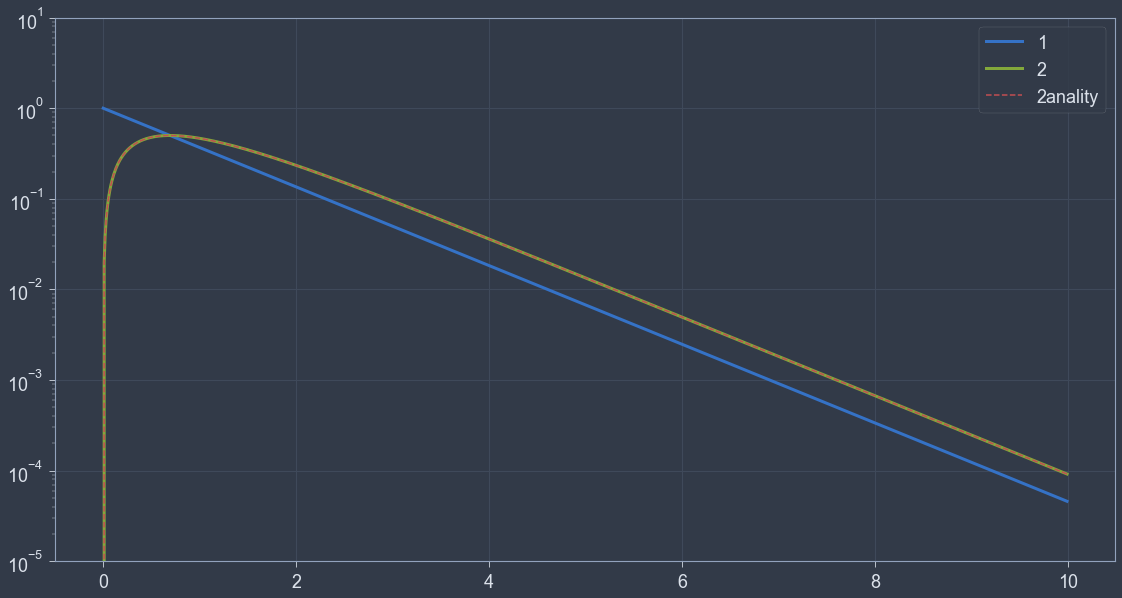

In [64]:
# Case A->B-> numerically
x0= np.array((1,0))
N= 1000
h= 0.01
t0= 0
l1= 1
l2= 2

def f(x,t):
    return np.array((-l1*x[0], l1*x[0]-l2*x[1])) 

y= ODE_RK4(x0,f,N,h,t0)


plt.figure(figsize=((19,10)))

T= np.arange(0,N*h,h)
plt.plot(T,l1*y[:,0], lw=3, label="1")
plt.plot(T,l2*y[:,1], lw=3, label="2")
plt.plot(T,l2*N2(T, l1, l2), lw=1.5, ls="--", label="2anality")
# plt.plot(T, l1*np.exp(-l1*T), ls="--")

plt.ylim((10**(-5),10))
plt.yscale("log")
plt.legend()

In [65]:
#Case at hand (testing)
x0= np.array( (1,0,0,0,0,0) )
N= 1000
h= 0.01
t0= 0
T= np.arange(0,N*h,h)

l1= 1
l23= 1
l24= 1
l3= 1
l4= 1
l5= 1

l2= l23+l24

def f(x,t):
    return np.array((-l1*x[0],
                     l1*x[0]-l2*x[1],
                    l23*x[1]-l3*x[2],
                    l24*x[1]-l4*x[3],
                    l3*x[2]+l4*x[3]-l5*x[4],
                     +l5*x[4])) 
y= np.transpose( ODE_RK4(x0,f,N,h,t0) )

# plt.plot(T, y[0]+y[1]+y[2]+y[3]+y[4]+y[5])

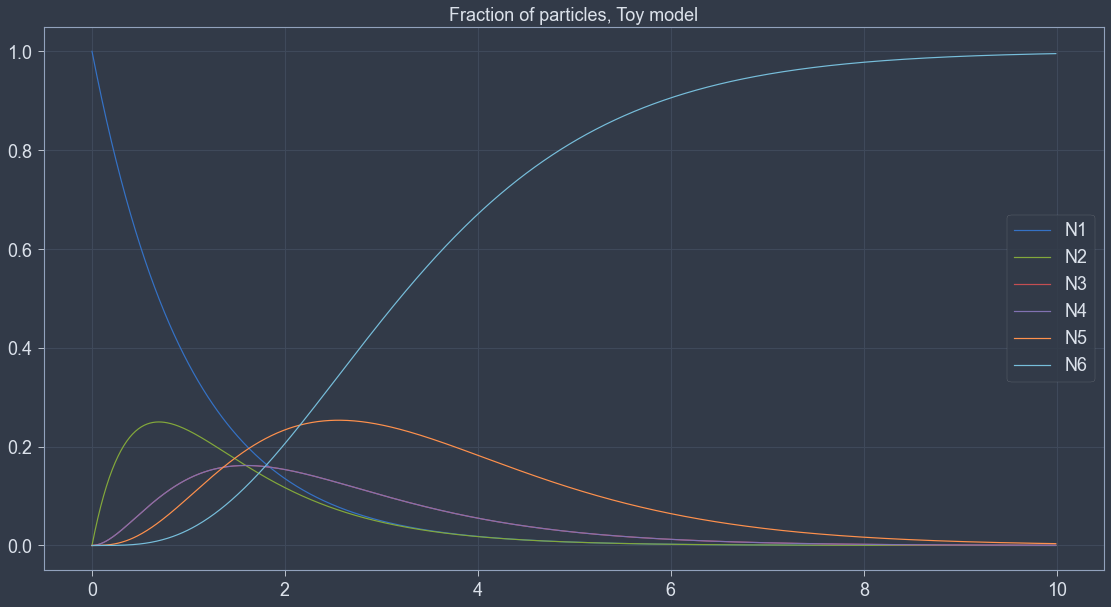

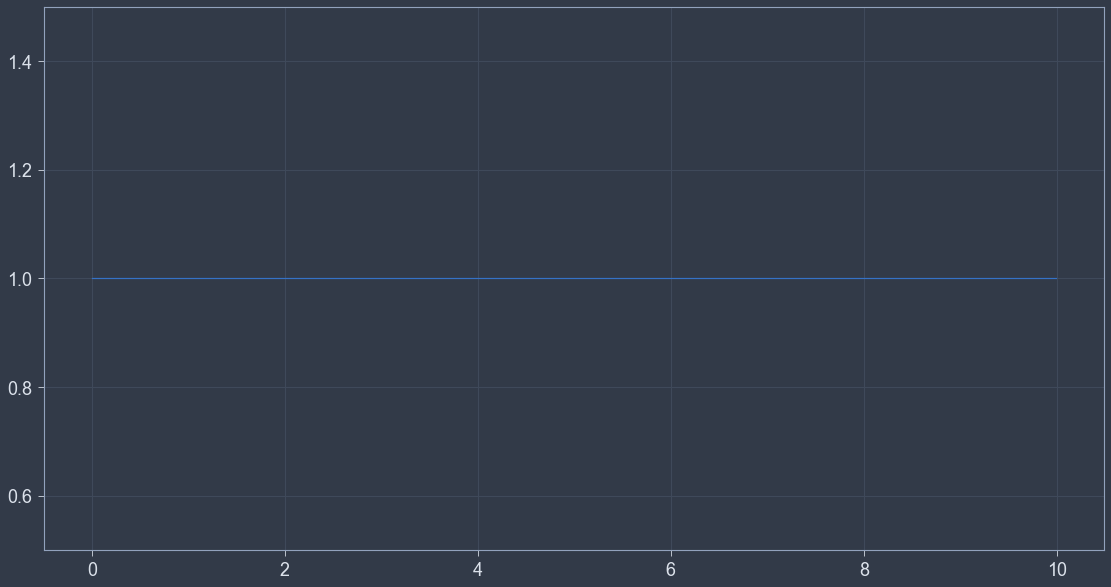

In [67]:
plt.figure( figsize=(19,10) )
plt.title("Fraction of particles, Toy model")
for i in range(len(x0)):
    plt.plot(T, y[i], label="N"+str(i+1))
plt.legend()
plt.show()

plt.figure( figsize=(19,10) )
plt.plot(T, y[0]+y[1]+y[2]+y[3]+y[4]+y[5])
plt.ylim((0.5,1.5))
plt.show()

# Realistic Case continuous irradiation

## Evolution of the system at minimal flux

We now apply the previous method with the realistic transition rates, and compare with analytical result. Note that they agree perfectly.

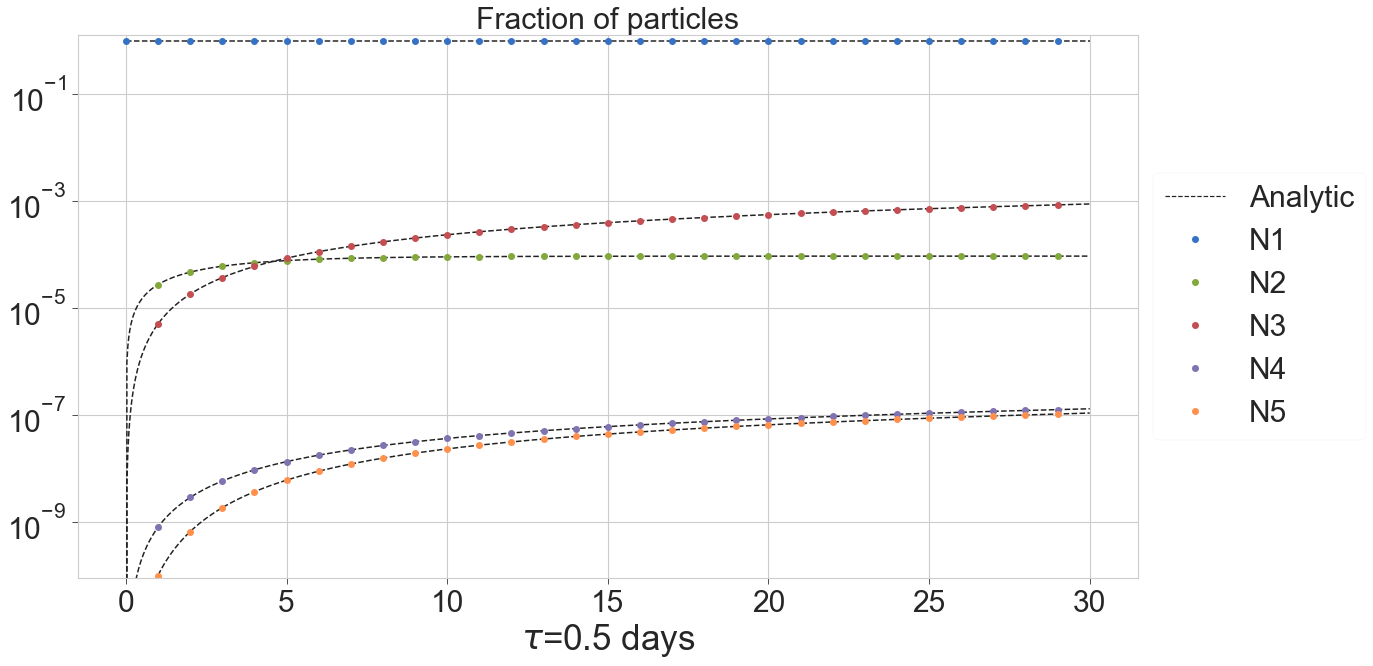

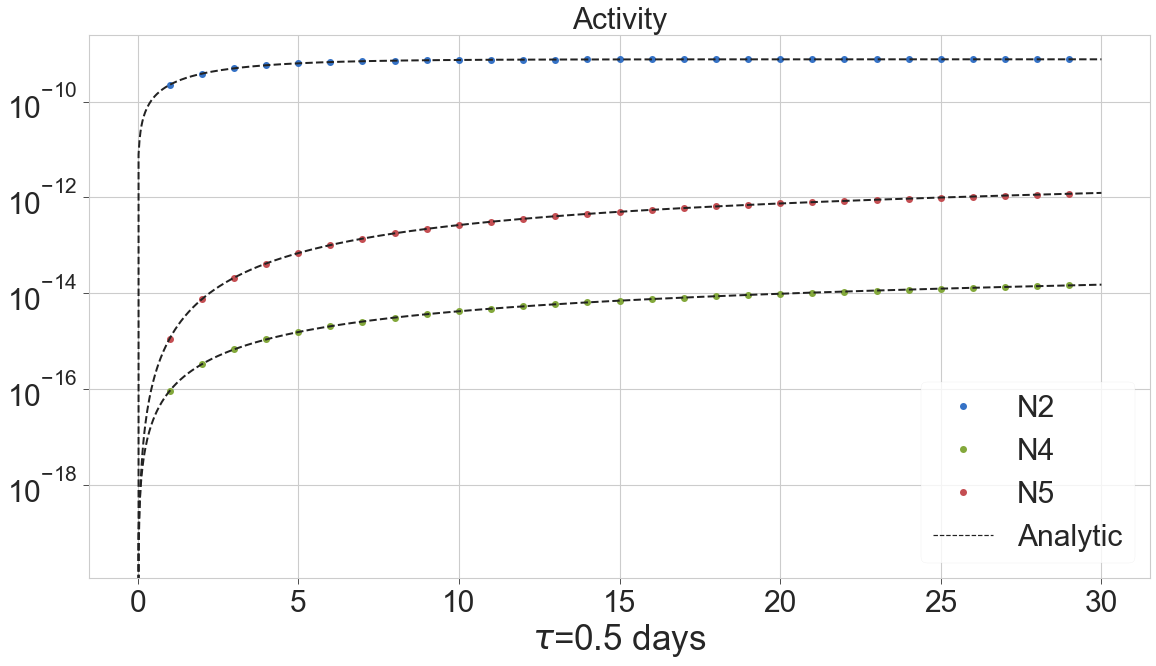

In [39]:
# Conditions
F= 2*10**13 # ord is the order factor on the flux 2*10^(ORD)

DefConst(F) # def constants for the given flux F
x0= np.array( (1,0,0,0,0,0) ) # initial conditions

# Run Runge-Kuta (RK)
N= 30
h= 24*60*60*(0.5) # time step
t0= 0
T= np.arange(0,N*h,h)

y= np.transpose( ODE_RK4(x0,f,N,h,t0) )

#------------------------------------------------------------------------------------------

# Fraction of particles plot
plt.figure( figsize=(19,10) )
plt.title("Fraction of particles")

# analytic
LW= 1.5
Ta= np.linspace(0, N*h, 1000)
plt.plot(Ta/h, N1(Ta, l1), "--k", lw=LW)
plt.plot(Ta/h, N2(Ta, l1, l2),"--k", lw=LW)
plt.plot(Ta/h, N4(Ta,l1,l23,l2,l3), "--k", lw=LW)
plt.plot(Ta/h, N4(Ta,l1,l24,l2,l4),"--k", lw=LW)
plt.plot(Ta/h, N5(Ta,l1,l23,l24,l3,l4,l5), "--k", lw=LW)
plt.plot(0,0, "k--", label= "Analytic")

# simulation
for i in range(len(x0)-1):
    plt.plot(T/h, y[i], "o", ms= 7, label="N"+str(i+1))
    
plt.ylim((0.9*10**(-10),1.3))
plt.yscale("log")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), markerscale=1)
plt.xlabel("$\\tau$="+str(h/(60*60*24))+" days")
plt.show()

#------------------------------------------------------------------------------------------

# Activity plot
plt.figure( figsize=(19,10) )
plt.title("Activity")

for i in (1,3,4):
    plt.plot(T/h, l_[i]*y[i], "o", ms= 7, label= "N"+str(i+1))

LW=2
Ta= np.linspace(0, N*h, 1000)
# plt.plot(Ta/h, l1*N1(Ta, l1), "--k", lw=LW)
plt.plot(Ta/h, l2*N2(Ta, l1, l2),"--k", lw=LW)
# plt.plot(Ta/h, l3*N4(Ta,l1,l23,l2,l3), "--k", lw=LW)
plt.plot(Ta/h, l4*N4(Ta,l1,l24,l2,l4),"--k", lw=LW)
plt.plot(Ta/h, l5*N5(Ta,l1,l23,l24,l3,l4,l5), "--k", lw=LW)
plt.plot(0,0, "k--", label= "Analytic")
    
plt.xlabel("$\\tau$="+str(h/(60*60*24))+" days")
plt.legend()
plt.yscale("log")
plt.show()

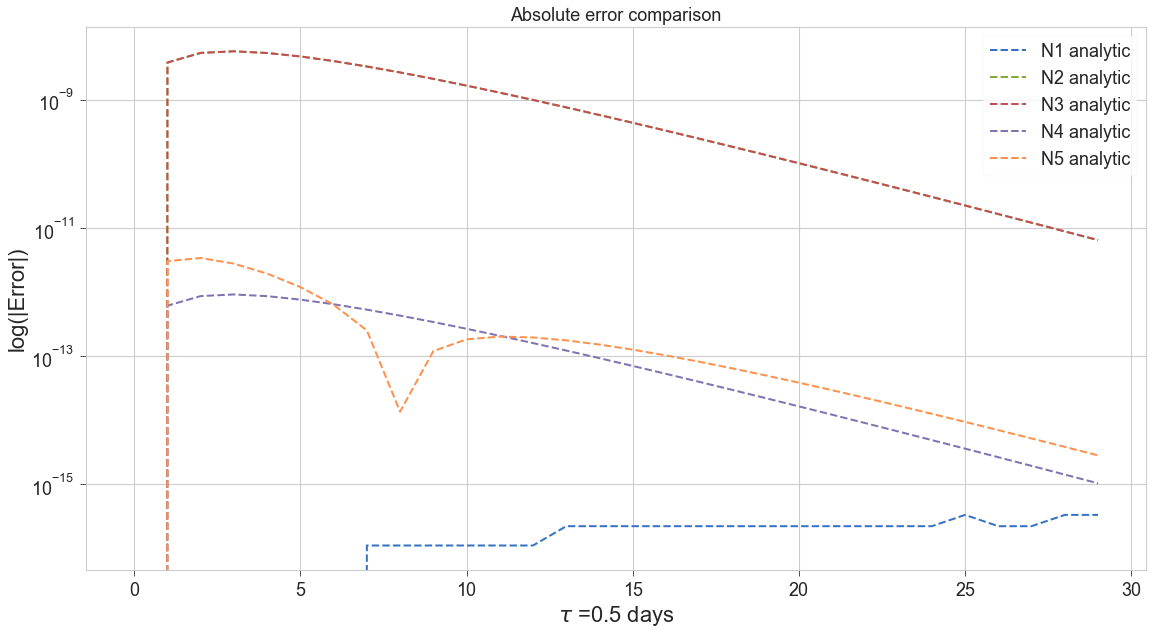

In [13]:
# Error comparison

plt.figure( figsize=(19,10) )
plt.title("Absolute error comparison")

LW=2 
plt.plot(T/h, np.abs(N1(T, l1)-y[0]), "--", lw=LW, label= "N1 analytic")
plt.plot(T/h, np.abs(N2(T, l1, l2)-y[1]),"--", lw=LW, label= "N2 analytic")
plt.plot(T/h, np.abs(N4(T,l1,l23,l2,l3)-y[2]), "--", lw=LW, label= "N3 analytic")
plt.plot(T/h, np.abs(N4(T,l1,l24,l2,l4)-y[3]),"--", lw=LW, label= "N4 analytic")
plt.plot(T/h, np.abs(N5(T,l1,l23,l24,l3,l4,l5)-y[4]), "--", lw=LW, label= "N5 analytic")

plt.yscale("log")
plt.legend()
plt.xlabel("$\\tau$ ="+str(h/(60*60*24))+" days")
plt.ylabel( "log(|Error|)" )
plt.show()

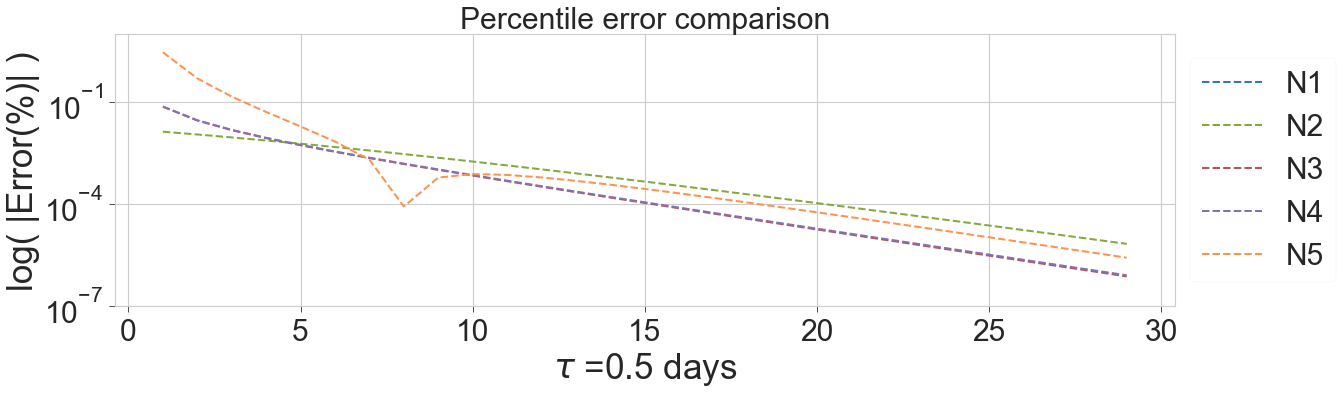

In [37]:
# Error comparison

plt.figure( figsize=(19,5) )
plt.title("Percentile error comparison")

LW=2 
plt.plot(T[1:]/h, 100*np.abs(N1(T[1:], l1)-y[0][1:])/N1(T[1:], l1) , "--", lw=LW, label= "N1")
plt.plot(T[1:]/h, 100*np.abs(N2(T[1:], l1, l2)-y[1][1:])/N2(T[1:], l1, l2) ,"--", lw=LW, label= "N2")
plt.plot(T[1:]/h, 100*np.abs(N4(T[1:],l1,l23,l2,l3)-y[2][1:])/N4(T[1:],l1,l23,l2,l3) , "--", lw=LW, label= "N3")
plt.plot(T[1:]/h, 100*np.abs(N4(T[1:],l1,l24,l2,l4)-y[3][1:])/N4(T[1:],l1,l24,l2,l4) ,"--", lw=LW, label= "N4")
plt.plot(T[1:]/h, 100*np.abs(N5(T[1:],l1,l23,l24,l3,l4,l5)-y[4][1:])/N5(T[1:],l1,l23,l24,l3,l4,l5) , "--", lw=LW, label= "N5")

plt.ylim((10**(-7),10))
plt.yscale("log")
plt.xlabel("$\\tau$ ="+str(h/(60*60*24))+" days")
plt.ylabel( "log( |Error(%)| )" )
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), markerscale=1)
plt.show()

In [25]:
# making paper image

## Activity dependency on the flux (this is wrong, need to multiply everything by decay rate)

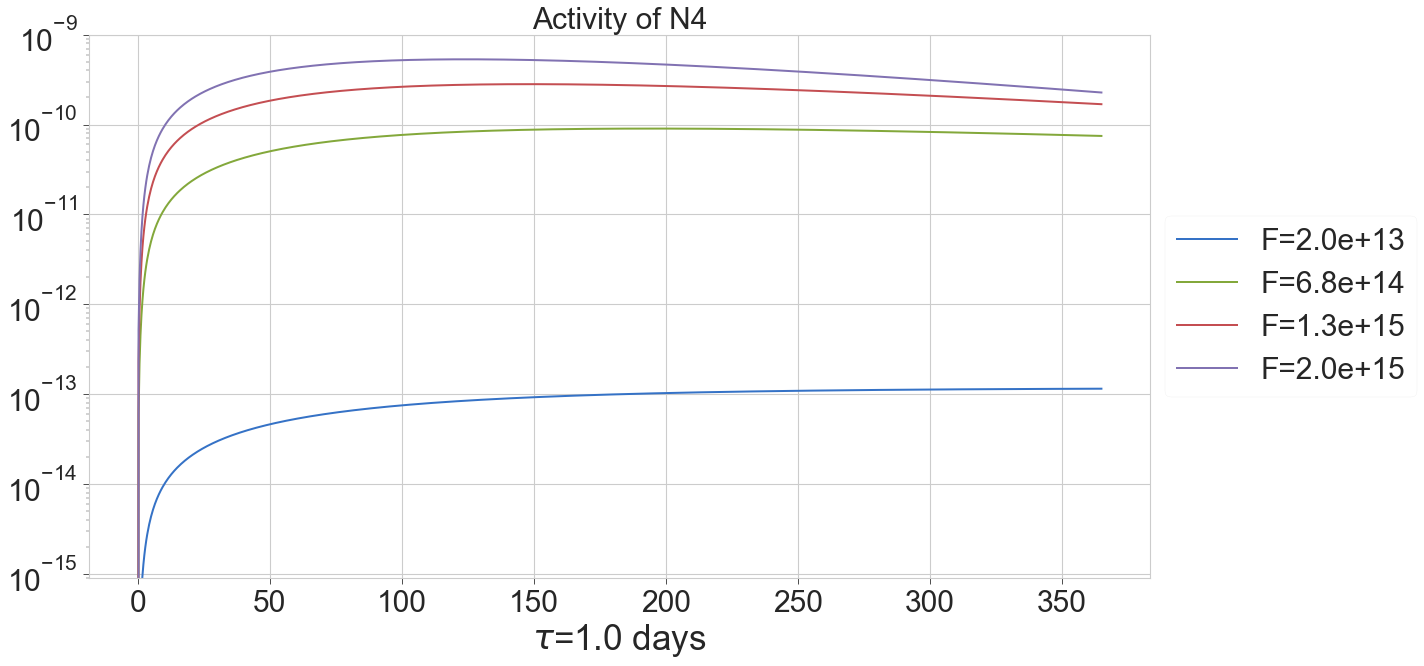

In [58]:
# F_= F* 10**( np.linspace(0,2,4) )   # list of different fluxes: F* 10^(k), 0<k<2  logspace
F_= F* np.linspace(1,10**2,4)         # list of different fluxes: F* k, 0<k<2       linspace

N= 365
points=1000
h= 24*60*60 # time step
T= np.linspace(0,N*h, points)


LW=2
# title= "Activity of N1"
# plt.figure( figsize=(19,10) )
# plt.title(title)
# for flx in F_:
#         DefConst(flx) # redifine constants for the flux
#         plt.plot(T/h, N1(T, l1), lw=LW, label= "Flux={:.2e}".format(flx))
# plt.yscale("log")
# plt.legend()
# plt.xlabel("$\\tau$="+str(h/(60*60*24))+" days")
# plt.show()

# title= "Activity of N2"
# plt.figure( figsize=(19,10) )
# plt.title(title)
# for flx in F_:
#         DefConst(flx) # redifine constants for the flux
#         plt.plot(T/h, N2(T, l1, l2), lw=LW, label= "Flux={:.2e}".format(flx))
# plt.yscale("log")
# plt.legend()
# plt.xlabel("$\\tau$="+str(h/(60*60*24))+" days")
# plt.show()

# title= "Activity of N3"
# plt.figure( figsize=(19,10) )
# plt.title(title)
# for flx in F_:
#         DefConst(flx) # redifine constants for the flux
#         plt.plot(T/h, N4(T,l1,l23,l2,l3), lw=LW, label= "Flux={:.2e}".format(flx))
# plt.yscale("log")
# plt.legend()
# plt.xlabel("$\\tau$="+str(h/(60*60*24))+" days")
# plt.show()

title= "Activity of N4"
plt.figure( figsize=(19,10) )
plt.title(title)
for flx in F_:
        DefConst(flx) # redifine constants for the flux
        plt.plot(T/h, l_[3]*N4(T,l1,l24,l2,l4), lw=LW, label= "F={:.1e}".format(flx))
plt.ylim((0.9*10**(-15),10**-9))
plt.yscale("log")
plt.xlabel("$\\tau$="+str(h/(60*60*24))+" days")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), markerscale=1)
plt.show()

# title= "Activity of N5"
# plt.figure( figsize=(19,10) )
# plt.title(title)
# for flx in F_:
#         DefConst(flx) # redifine constants for the flux
#         plt.plot(T/h, N5(T,l1,l23,l24,l3,l4,l5), lw=LW, label= "Flux={:.2e}".format(flx))
# plt.yscale("log")
# plt.legend()
# plt.xlabel("$\\tau$="+str(h/(60*60*24))+" days")
# plt.show()

    
# N1(t, l1)
# N2(t, l1, l2)
# N4(t,l1,l2_4,l2,l4)
# N5(t,l1,l2_3,l2_4,l3,l4,l5)

## Maximal value of Re activity

### Old way: brute force

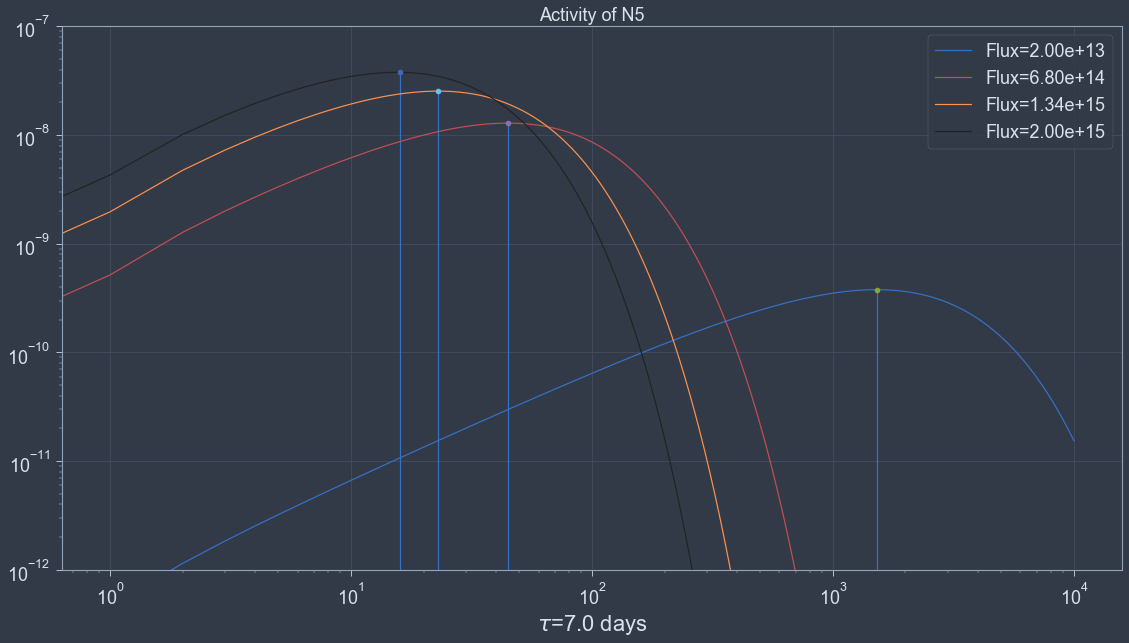

In [22]:
F_= F* np.linspace(1,10**2,4)
# Run analytic solution
N= 10000
h= 24*60*60*7 # time step
T= np.arange(0,N*h,h)

plt.figure( figsize=(19,10) )
plt.title("Activity of N5")

for flx in F_:
    DefConst(flx) # redifine constants for the flux
    
    N5_run= N5(T,l1,l23,l24,l3,l4,l5)
    N5_aMax= np.argmax(N5_run)
    N5_Max= N5(T[N5_aMax],l1,l23,l24,l3,l4,l5)

    # find max of N5 activity

    plt.plot(T/h, l_[4]*N5_run, label= "Flux={:.2e}".format(flx))

    plt.plot(T[N5_aMax]/h, l_[4]*N5_Max, "o" )
    plt.vlines(T[N5_aMax]/h,0,l_[4]*N5_Max)
    
#         plt.annotate("sup{N5(t)}=" +str(N5_Max), (1,l_[4]*N5_Max))

    
# plt.ylim( (1.5*l_[4]*N5_run[1], 1.5*l_[4]*N5_Max ) )
plt.ylim( (10**-12, 10**-7 ))
plt.xlabel("$\\tau$="+str(h/(60*60*24))+" days")

plt.yscale("log")
plt.xscale("log")
plt.legend()
plt.show()

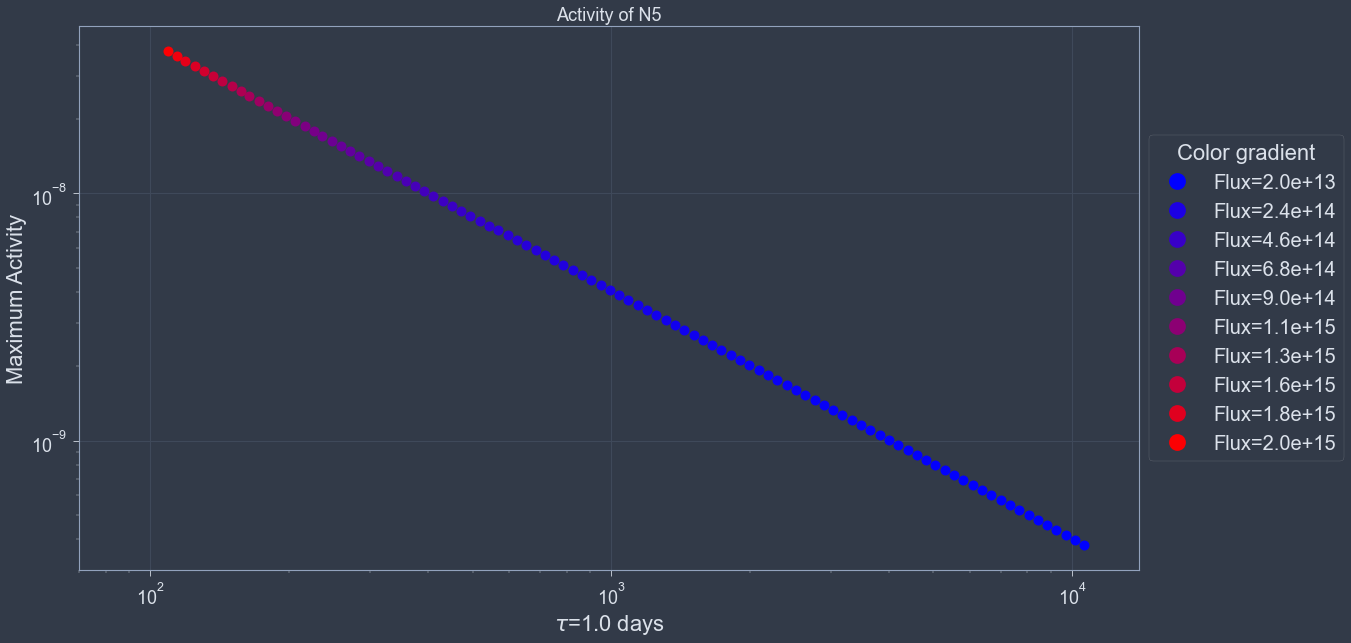

In [25]:
# Run analytic solution
F_= F* np.logspace(0,2,100) # in a logspace to get linear dist
N= 10000*7
h= 24*60*60 # time step
T= np.arange(0,N*h,h)

plt.figure( figsize=(19,10) )
plt.title("Activity of N5")

for flx in F_:
    cr= (flx-F_[0])/F_[-1] # colour factor red
    DefConst(flx) # redifine constants for the flux
    
    N5_run= N5(T,l1,l23,l24,l3,l4,l5)
    N5_aMax= np.argmax(N5_run)
    N5_Max= N5(T[N5_aMax],l1,l23,l24,l3,l4,l5)

    plt.plot(T[N5_aMax]/h , l_[4]*N5_Max , "o", ms=10 , color= (cr,0,1-cr))
    
for flx in np.linspace(F_[0],F_[-1],10):
    cr= (flx-F_[0])/F_[-1] # colour factor red
    plt.plot(0 ,0 , "o", color= (cr,0,1-cr), label="Flux={:.1e}".format(flx))
    
    
# plt.ylim( (1.5*l_[4]*N5_run[1], 1.5*l_[4]*N5_Max ) )
# plt.ylim( (10**-12, 10**-7 ))
plt.xlim( (10*7, 7*2*10**3 ))
plt.ylabel("Maximum Activity")
plt.xlabel("$\\tau$="+str(h/(60*60*24))+" days")

plt.yscale("log")
plt.xscale("log")
plt.legend(loc='center left', title="Color gradient", bbox_to_anchor=(1, 0.5), fontsize=20, markerscale=3)
plt.show()

### Smart way: golden ration maximum search

In [59]:
# F_ is the list to find the maxima
# F_= F* np.linspace(1,10**2,4)
F_= np.zeros(1)
F_[0]= 2*10**15
tmax= 24*60*60*7*10000
eps= 60*60

t_= np.zeros(len(F_))
for i in range(len(t_)): # find each t for each the activity is at a maximum
    DefConst(F_[i])
    lamb= lambda x: N5(x,l1,l23,l24,l3,l4,l5)
    t_[i]=GoldenSearch(lamb,1,tmax,eps,r=-1)
    
print(t_/(24*60*60*7))

[15.57901321]


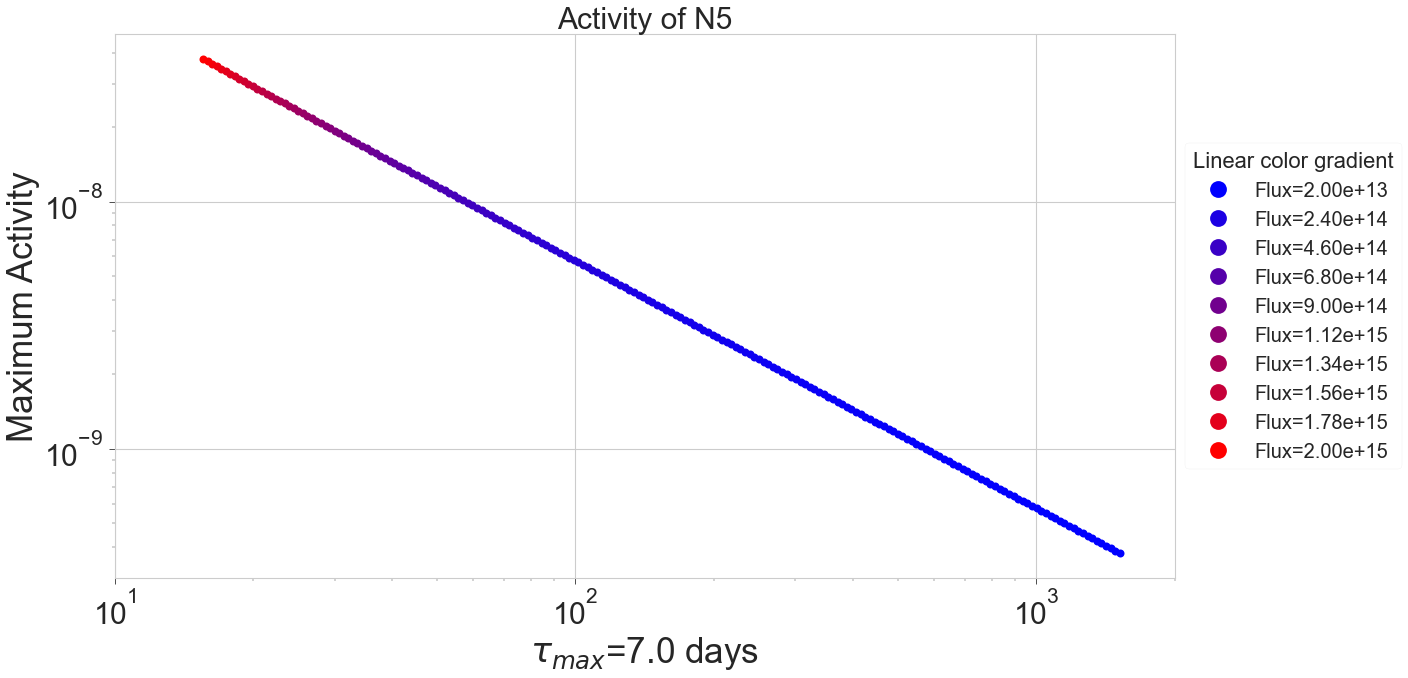

In [60]:
# Run analytic solution
F_= F* np.logspace(0,2,200) # in a logspace to get linear dist

tmax= 24*60*60*7*10000 # maximum time of search, set it to a time after 
                    #to lowest maximum to find all solutions
eps= 60*60 # accuracy

t_= np.zeros(len(F_))
for i in range(len(t_)):
    DefConst(F_[i])
    lamb= lambda x: N5(x,l1,l23,l24,l3,l4,l5)
    t_[i]= GoldenSearch(lamb,1,tmax,eps,r=-1)

# plot
h= 24*60*60*7 # time step
plt.figure( figsize=(19,10) )
plt.title("Activity of N5")

for i in range(len(t_)):
    DefConst(F_[i])
    cr= (F_[i]-F_[0])/(F_[-1]-F_[0]) # colour factor red
    plt.plot(t_[i]/h , l_[4]*N5(t_[i],l1,l23,l24,l3,l4,l5) , "o", ms= 8 , color= (cr,0,1-cr))
    
for flx in np.linspace(F_[0],F_[-1],10):
    cr= (flx-F_[0])/(F_[-1]-F_[0]) # colour factor red
    plt.plot(0 ,0 , "o", color= (cr,0,1-cr), label="Flux={:.2e}".format(flx))
    
    
plt.ylabel("Maximum Activity")
plt.xlabel("$\\tau_{max}$="+str(h/(60*60*24))+" days")

plt.xlim(10,10**3 *2)
plt.yscale("log")
plt.xscale("log")
plt.legend(loc='center left', title="Linear color gradient", bbox_to_anchor=(1, 0.5), fontsize=20, markerscale=3)
plt.show()

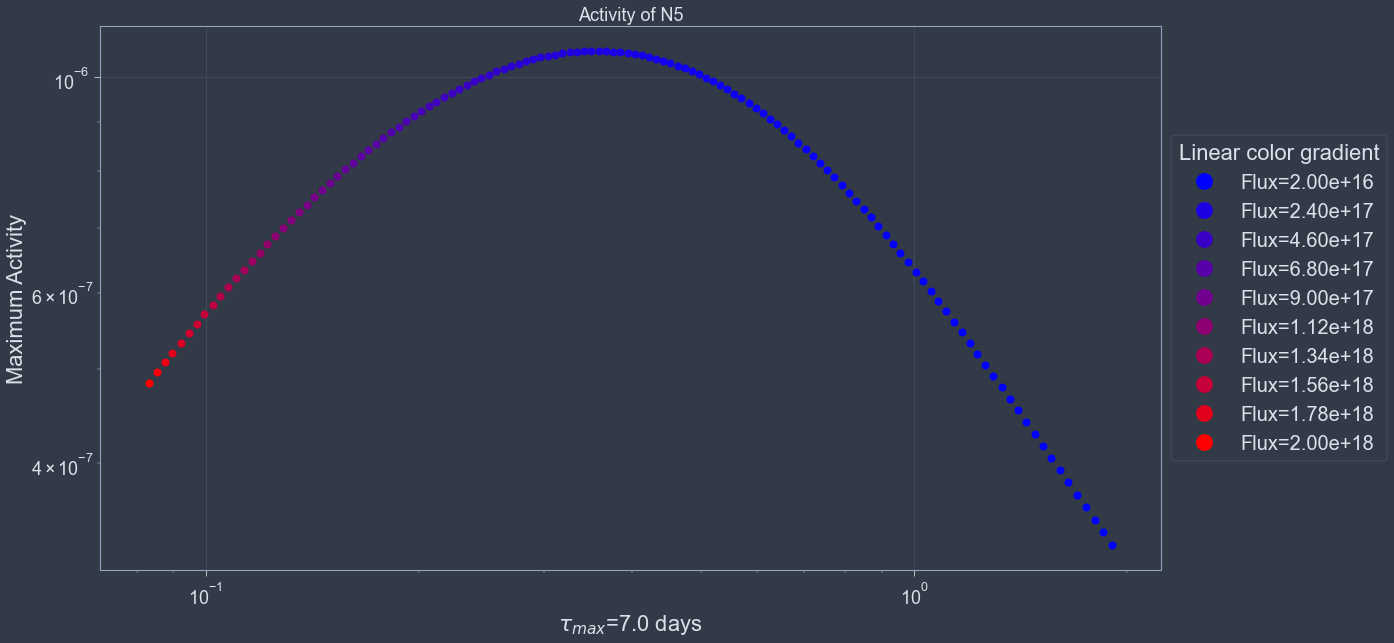

In [35]:
# Looking for the flux that maximizes the number of samples
F_= F* np.logspace(3,5,2**7) # in a logspace to get linear dist

tmax= 24*60*60*7*10000 # maximum time of search, set it to a time after 
                    #to lowest maximum to find all solutions
eps= 60*60*(0.1) # accuracy

t_= np.zeros(len(F_))
for i in range(len(t_)):
    DefConst(F_[i])
    lamb= lambda x: N5(x,l1,l23,l24,l3,l4,l5)
    t_[i]= GoldenSearch(lamb,1,tmax,eps,r=-1)

# plot
h= 24*60*60*7 # time step
plt.figure( figsize=(19,10) )
plt.title("Activity of N5")

for i in range(len(t_)):
    DefConst(F_[i])
    cr= (F_[i]-F_[0])/(F_[-1]-F_[0]) # colour factor red
    plt.plot(t_[i]/h , l_[4]*N5(t_[i],l1,l23,l24,l3,l4,l5) , "o", ms= 8 , color= (cr,0,1-cr))
    
for flx in np.linspace(F_[0],F_[-1],10):
    cr= (flx-F_[0])/(F_[-1]-F_[0]) # colour factor red
    plt.plot(0 ,0 , "o", color= (cr,0,1-cr), label="Flux={:.2e}".format(flx))
    
    
plt.ylabel("Maximum Activity")
plt.xlabel("$\\tau_{max}$="+str(h/(60*60*24))+" days")

plt.yscale("log")
plt.xscale("log")
plt.legend(loc='center left', title="Linear color gradient", bbox_to_anchor=(1, 0.5), fontsize=20, markerscale=3)
plt.show()

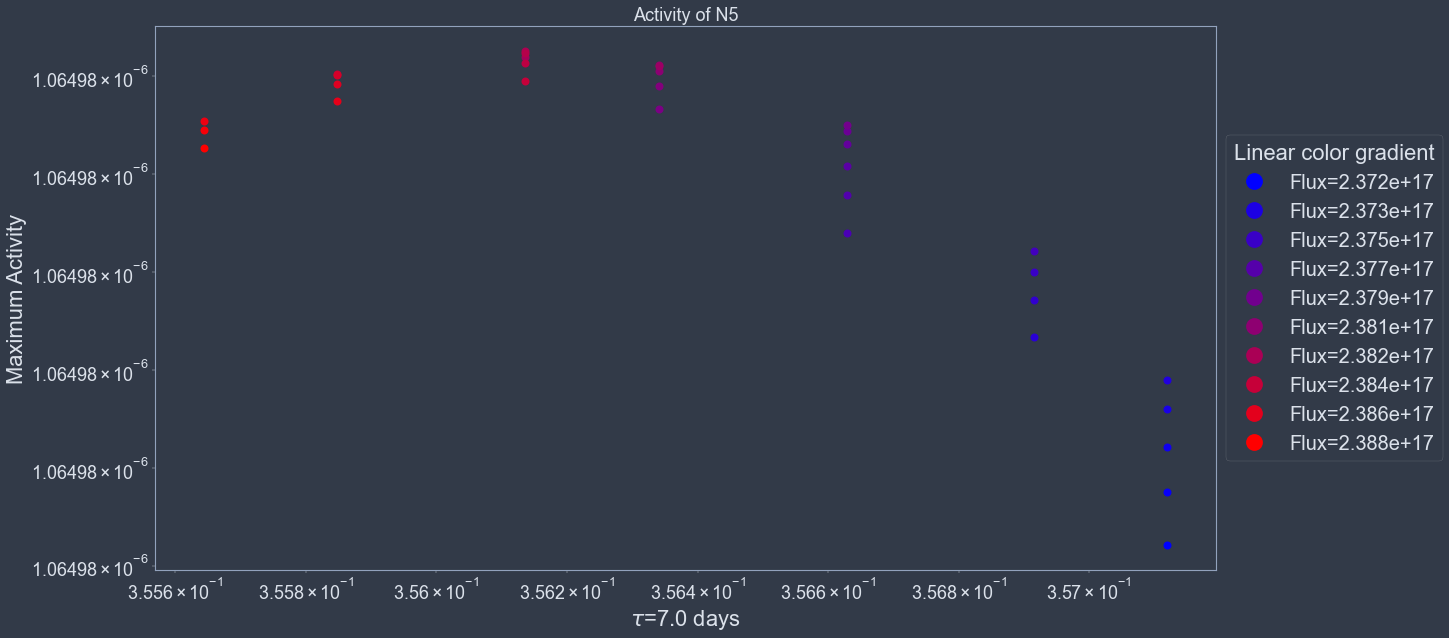

In [38]:
# Looking for the flux that maximizes the number of samples
F_= F* np.logspace(4.074,4.077,2**5) # in a logspace to get linear dist

tmax= 24*60*60*7*10000 # maximum time of search, set it to a time after 
                    #to lowest maximum to find all solutions
eps= 60*60*(0.1) # accuracy

t_= np.zeros(len(F_))
for i in range(len(t_)):
    DefConst(F_[i])
    lamb= lambda x: N5(x,l1,l23,l24,l3,l4,l5)
    t_[i]= GoldenSearch(lamb,1,tmax,eps,r=-1)

# plot
h= 24*60*60*7 # time step
plt.figure( figsize=(19,10) )
plt.title("Activity of N5")

for i in range(len(t_)):
    DefConst(F_[i])
    cr= (F_[i]-F_[0])/(F_[-1]-F_[0]) # colour factor red
    plt.plot(t_[i]/h , l_[4]*N5(t_[i],l1,l23,l24,l3,l4,l5) , "o", ms= 8 , color= (cr,0,1-cr))
    
for flx in np.linspace(F_[0],F_[-1],10):
    cr= (flx-F_[0])/(F_[-1]-F_[0]) # colour factor red
    plt.plot(0 ,0 , "o", color= (cr,0,1-cr), label="Flux={:.3e}".format(flx))
    
    
plt.ylabel("Maximum Activity")
plt.xlabel("$\\tau$="+str(h/(60*60*24))+" days")

plt.yscale("log")
plt.xscale("log")
plt.legend(loc='center left', title="Linear color gradient", bbox_to_anchor=(1, 0.5), fontsize=20, markerscale=3)
plt.show()

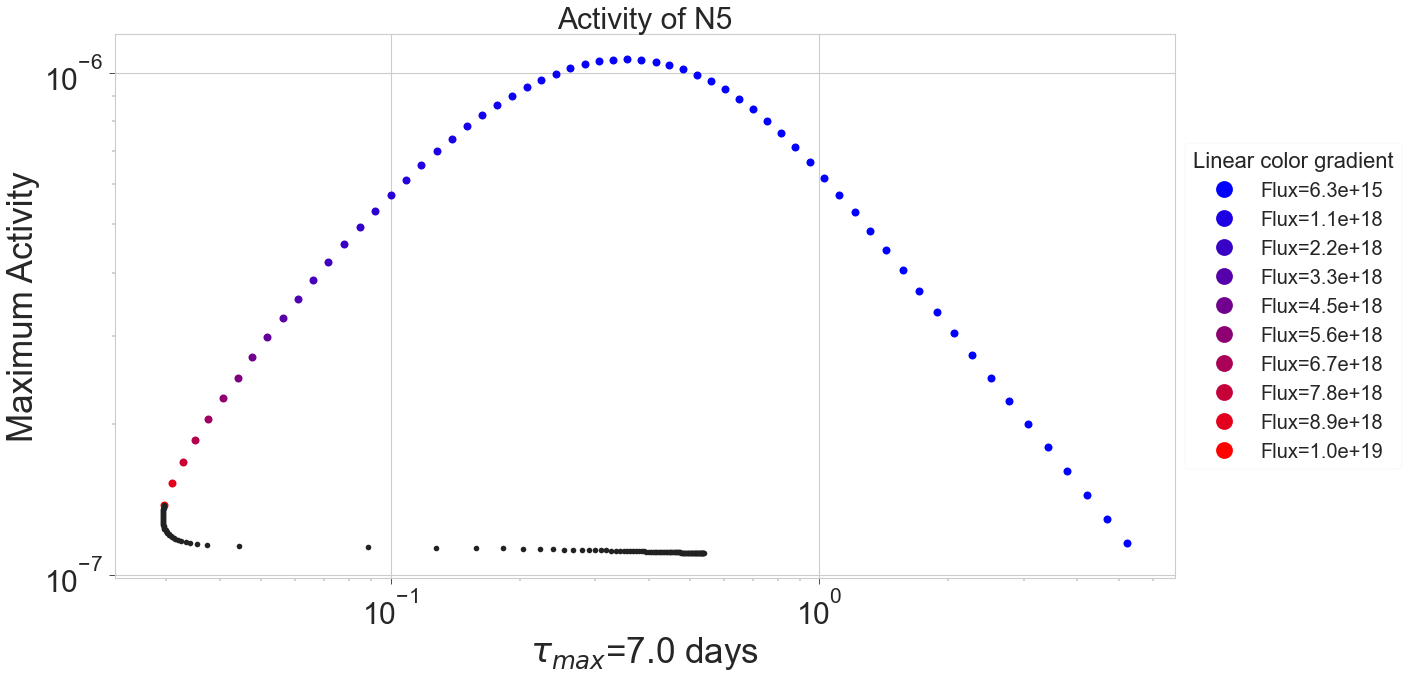

In [61]:
# Looking for the flux saturation
F_= F* np.logspace(2.5,5.7,2**6) # in a logspace to get linear dist
F_new= F* np.logspace(5.7,6,2**7)

tmax= 24*60*60*7*10000 # maximum time of search, set it to a time after 
                    #to lowest maximum to find all solutions
eps= 60*60*(0.1) # accuracy

t_= np.zeros(len(F_))
for i in range(len(t_)):
    DefConst(F_[i])
    lamb= lambda x: N5(x,l1,l23,l24,l3,l4,l5)
    t_[i]= GoldenSearch(lamb,1,tmax,eps,r=-1)
    
t_new= np.zeros(len(F_new))
for i in range(len(t_new)):
    DefConst(F_new[i])
    lamb= lambda x: N5(x,l1,l23,l24,l3,l4,l5)
    t_new[i]= GoldenSearch(lamb,1,tmax,eps,r=-1)

# plot
h= 24*60*60*7 # time step
plt.figure( figsize=(19,10) )
plt.title("Activity of N5")

for i in range(len(t_)):
    DefConst(F_[i])
    cr= (F_[i]-F_[0])/(F_[-1]-F_[0]) # colour factor red
    plt.plot(t_[i]/h , l_[4]*N5(t_[i],l1,l23,l24,l3,l4,l5) , "o", ms= 8 , color= (cr,0,1-cr))
    
for i in range(len(t_new)):
    DefConst(F_new[i])
    plt.plot(t_new[i]/h , l_[4]*N5(t_new[i],l1,l23,l24,l3,l4,l5) , "ko")
    
for flx in np.linspace(F_[0],F_[-1],10):
    cr= (flx-F_[0])/(F_[-1]-F_[0]) # colour factor red
    plt.plot(0 ,0 , "o", color= (cr,0,1-cr), label="Flux={:.1e}".format(flx))
    
    
plt.ylabel("Maximum Activity")
plt.xlabel("$\\tau_{max}$="+str(h/(60*60*24))+" days")

plt.yscale("log")
plt.xscale("log")
plt.legend(loc='center left', title="Linear color gradient", bbox_to_anchor=(1, 0.5), fontsize=20, markerscale=3)
plt.show()

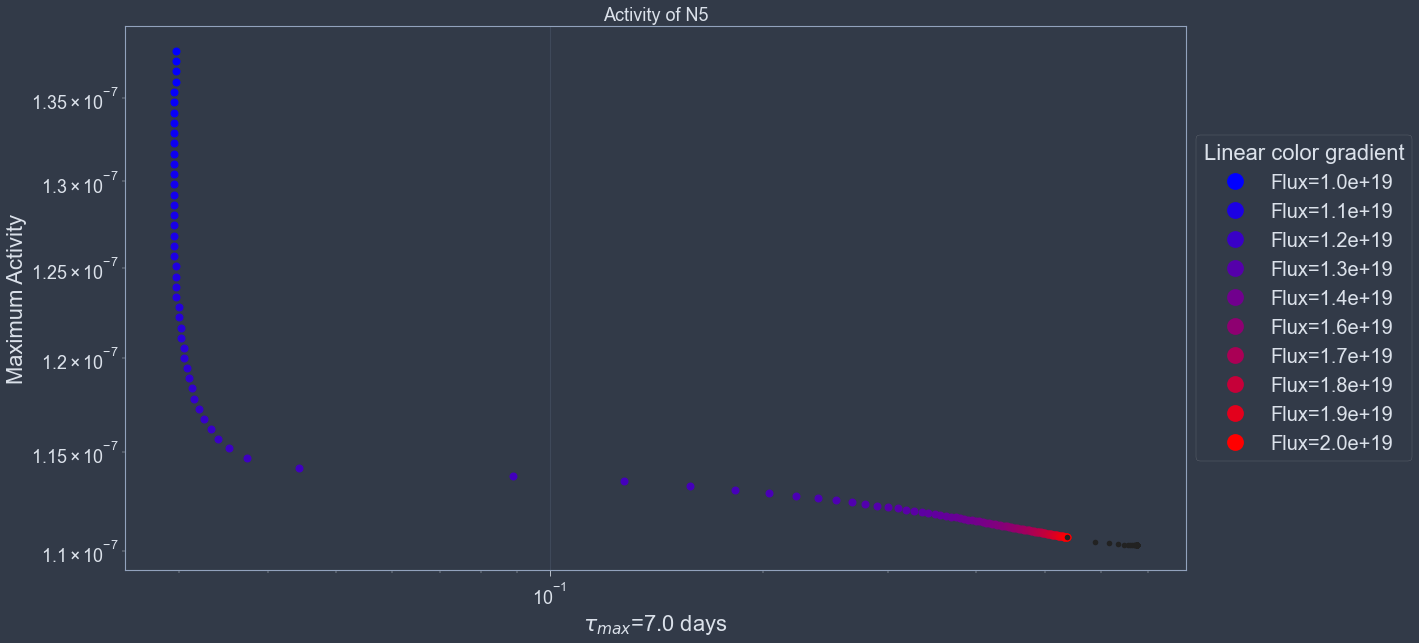

In [46]:
# Looking for the flux saturation

F_= F* np.logspace(5.7,6,2**7) # in a logspace to get linear dist
F_new= F* np.logspace(6,10,2**5)


tmax= 24*60*60*7*10000 # maximum time of search, set it to a time after 
                    #to lowest maximum to find all solutions
eps= 60*60*(0.1) # accuracy

t_= np.zeros(len(F_))
for i in range(len(t_)):
    DefConst(F_[i])
    lamb= lambda x: N5(x,l1,l23,l24,l3,l4,l5)
    t_[i]= GoldenSearch(lamb,1,tmax,eps,r=-1)
    
t_new= np.zeros(len(F_new))
for i in range(len(t_new)):
    DefConst(F_new[i])
    lamb= lambda x: N5(x,l1,l23,l24,l3,l4,l5)
    t_new[i]= GoldenSearch(lamb,1,tmax,eps,r=-1)

# plot
h= 24*60*60*7 # time step
plt.figure( figsize=(19,10) )
plt.title("Activity of N5")

for i in range(len(t_)):
    DefConst(F_[i])
    cr= (F_[i]-F_[0])/(F_[-1]-F_[0]) # colour factor red
    plt.plot(t_[i]/h , l_[4]*N5(t_[i],l1,l23,l24,l3,l4,l5) , "o", ms= 8 , color= (cr,0,1-cr))
    
for i in range(len(t_new)):
    DefConst(F_new[i])
    plt.plot(t_new[i]/h , l_[4]*N5(t_new[i],l1,l23,l24,l3,l4,l5) , "ko")
    
for flx in np.linspace(F_[0],F_[-1],10):
    cr= (flx-F_[0])/(F_[-1]-F_[0]) # colour factor red
    plt.plot(0 ,0 , "o", color= (cr,0,1-cr), label="Flux={:.1e}".format(flx))
    
    
plt.ylabel("Maximum Activity")
plt.xlabel("$\\tau_{max}$="+str(h/(60*60*24))+" days")

plt.yscale("log")
plt.xscale("log")
plt.legend(loc='center left', title="Linear color gradient", bbox_to_anchor=(1, 0.5), fontsize=20, markerscale=3)
plt.show()

## Optimal running time !(Method of zeros is wrong)

We see that that running the process until $ t_{max} $ is not optimal as the derivative sharply declines when nearing the maximum. To make this more efficient we can only run the process to a time  $ t_{optimal} $, where $ N5(t_{optimal})= c \cdot N5_{}max  $, where $0<c<1$.


There are other ways to optimize for this problem, one could maximize production rate, minimize produced waste, or in industry applications maximize profits (taking into account raw material cost, selling price per unit of produced material, cost (and time) of extraction, recycling of intermidiate products, etc...); in this case we are only interested in an estimate of this optimal time, thus we take the previously mentioned simple method.


This method is equivalent to finding the zero of $ N5(t)- c \cdot N5_{}max  $, this can be done numerically, by using a bisection algorithm, for example.

In [8]:
# first test
def FindZero(f,x1,x4,eps): # modified to find zeros
    """
    r=1 finds minima, r=-1 finds maxima
    eps: accuracy
    """
    d= (x4-x1)*(5**(1/2)-1)/2
    x2= x4-d
    x3= x1+d
    
    while np.abs(x4-x1)>eps:
        
        if 0<f(x3):
            x4= x3
            x3= x2
            x2= x1+ x4- x3
        else:
            x1= x2
            x2= x3
            x3= x4- x2+ x1
        
    return (x1+x4)/2

F_= F* np.linspace(1,10**2,4)
tmax= 24*60*60*7*10000
eps= 60*60

t_= np.zeros(len(F_))
t_op= np.zeros(len(F_))
for i in range(len(t_)): # find each t for each the activity is at a maximum
    DefConst(F_[i])
    lamb= lambda x: N5(x,l1,l23,l24,l3,l4,l5)
    t_[i]= GoldenSearch(lamb,1,tmax,eps,r=-1)
    lambop= lambda x: N5(x,l1,l23,l24,l3,l4,l5) -c*N5(t_[i],l1,l23,l24,l3,l4,l5)
    t_op[i]= FindZero(lambop,0,t_[i],eps)

<ipython-input-2-5aa15ffc3bdf>:138: RuntimeWarning: divide by zero encountered in double_scalars
  o+=l1*l2i[i]*l[i]/(l2-l1)*( np.exp(-l1*t)/(l[i]-l1)/(l5-l1)
<ipython-input-2-5aa15ffc3bdf>:139: RuntimeWarning: divide by zero encountered in double_scalars
  -np.exp(-l2*t)/(l[i]-l2)/(l5-l2) -(l1-l2)*np.exp(-l[i]*t)/(l[i]-l1)/(l[i]-l2)/(l5-l[i]) )
<ipython-input-2-5aa15ffc3bdf>:138: RuntimeWarning: invalid value encountered in double_scalars
  o+=l1*l2i[i]*l[i]/(l2-l1)*( np.exp(-l1*t)/(l[i]-l1)/(l5-l1)
<ipython-input-2-5aa15ffc3bdf>:128: RuntimeWarning: divide by zero encountered in double_scalars
  o+=l1*l2i[i]*l[i]/(l2-l1)*( 1/(l[i]-l1)/(l5-l1)
<ipython-input-2-5aa15ffc3bdf>:129: RuntimeWarning: divide by zero encountered in double_scalars
  -1/(l[i]-l2)/(l5-l2) -(l1-l2)/(l[i]-l1)/(l[i]-l2)/(l5-l[i]) )
<ipython-input-2-5aa15ffc3bdf>:128: RuntimeWarning: invalid value encountered in double_scalars
  o+=l1*l2i[i]*l[i]/(l2-l1)*( 1/(l[i]-l1)/(l5-l1)


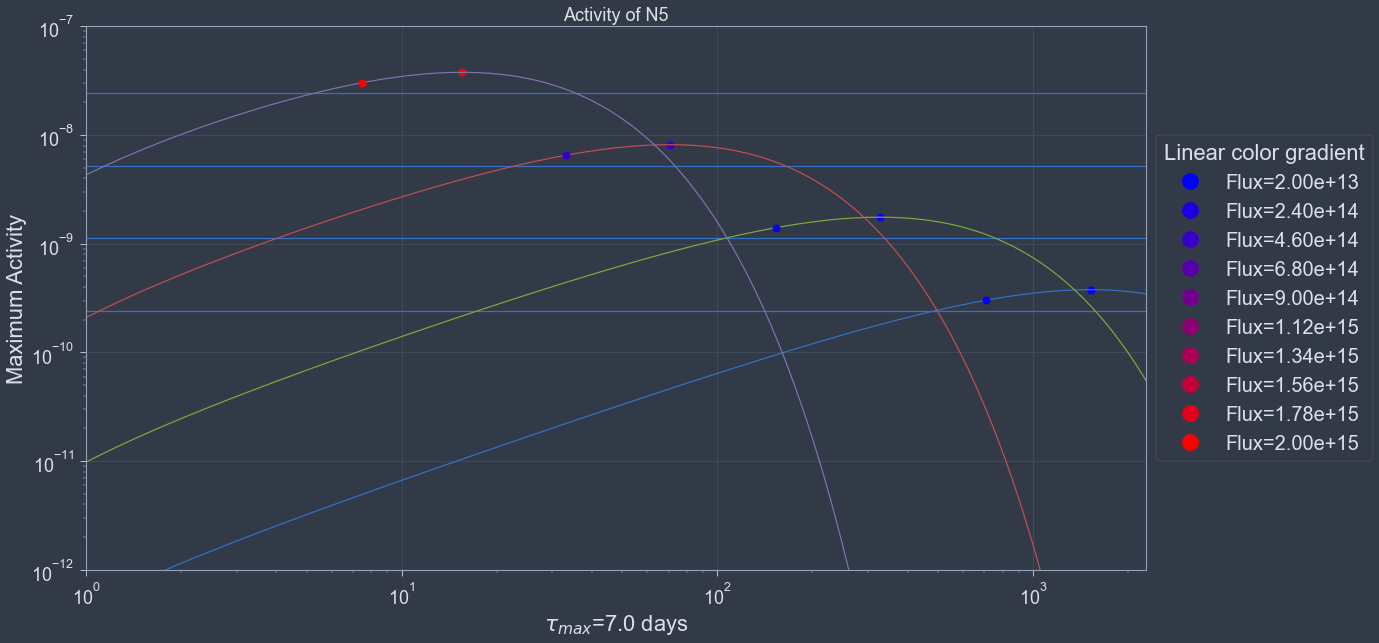

In [55]:
F_= F* np.logspace(0,2,4) # in a logspace to get linear dist
tmax= 24*60*60*7*10000 # maximum time of search, set it to a time after 
                    #to lowest maximum to find all solutions
eps= 60*60 # accuracy
c= 0.8

t_= np.zeros(len(F_))
t_op= np.zeros(len(F_))
for i in range(len(t_)): # find each t for each the activity is at a maximum
    DefConst(F_[i])
    lamb= lambda x: N5(x,l1,l23,l24,l3,l4,l5)
    t_[i]= GoldenSearch(lamb,1,tmax,eps,r=-1)
    lambop= lambda x: N5(x,l1,l23,l24,l3,l4,l5) -c*N5(t_[i],l1,l23,l24,l3,l4,l5)
    t_op[i]= FindZero(lambop,0,t_[i],eps)

# plot
h= 24*60*60*7 # time step
plt.figure( figsize=(19,10) )
plt.title("Activity of N5")

T= np.logspace(2, np.log(t_[0]), 1000)
for i in range(len(t_)):
    DefConst(F_[i])
    cr= (F_[i]-F_[0])/(F_[-1]-F_[0]) # colour factor red
    plt.plot(t_[i]/h , l_[4]*N5(t_[i],l1,l23,l24,l3,l4,l5) , "o", ms= 8 , color= (cr,0,1-cr))
    plt.plot(T/h, l_[4]*N5(T,l1,l23,l24,l3,l4,l5))
    
for i in range(len(t_op)):
    DefConst(F_[i])
    cr= (F_[i]-F_[0])/(F_[-1]-F_[0]) # colour factor red
    plt.plot(t_op[i]/h , l_[4]*N5(t_op[i],l1,l23,l24,l3,l4,l5) , "o", ms= 8 , color= (cr,0,1-cr))
    plt.hlines( c*l_[4]*N5(t_op[i],l1,l23,l24,l3,l4,l5), 1, t_[i] ) 
 
# generate legend
for flx in np.linspace(F_[0],F_[-1],10):
    DefConst(flx)
    cr= (flx-F_[0])/(F_[-1]-F_[0]) # colour factor red
    plt.plot(0 ,0 , "o", color= (cr,0,1-cr), label="Flux={:.2e}".format(flx))
    
    
plt.ylabel("Maximum Activity")
plt.xlabel("$\\tau_{max}$="+str(h/(60*60*24))+" days")

plt.ylim( (10**-12, 10**-7 ))
plt.xlim( (1, t_[0]*1.5/h ))
plt.yscale("log")
plt.xscale("log")
plt.legend(loc='center left', title="Linear color gradient", bbox_to_anchor=(1, 0.5), fontsize=20, markerscale=3)
plt.show()

## Sample cooling - !not working

After stopping the neutron flux there will be two decay chains: (1) $^{187} W \to ^{187} Re$, (2) $^{188} W \to ^{188} Re \to ^{188} Os $. The first decay chain will be be a simple exponential decay law, the second one will also be a fairly simple decay law, same analytial solutions as before, only with the need to change the initial conditions. We can also simulate this, allowing us to quickly plot the cooling of the sample at any given starting condition, for example the previously determined optimal running time final conditions.

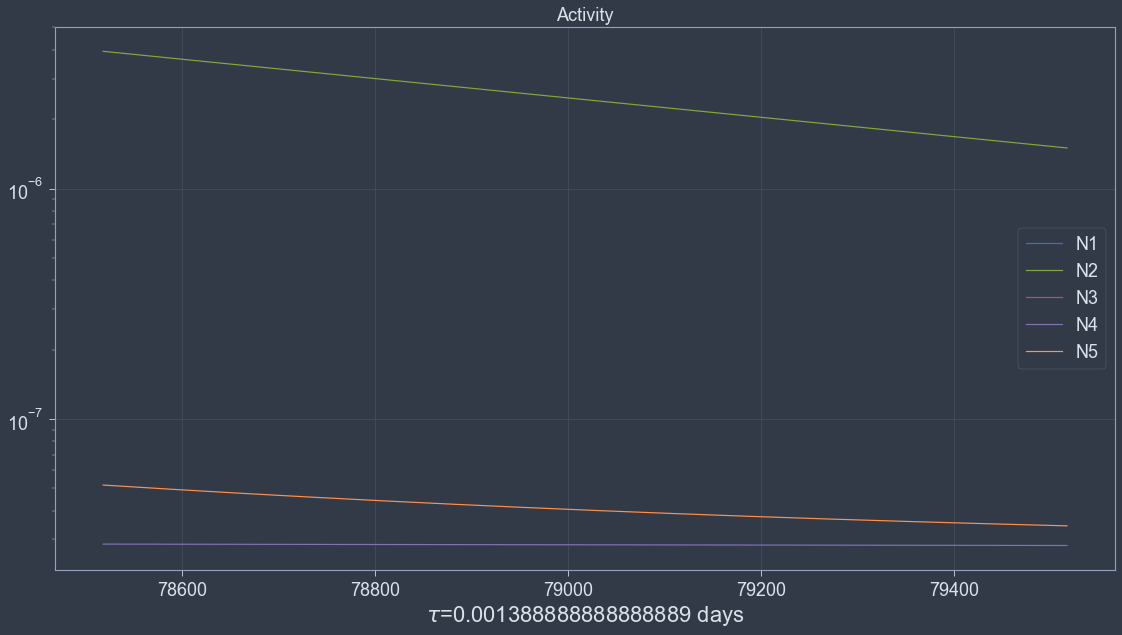

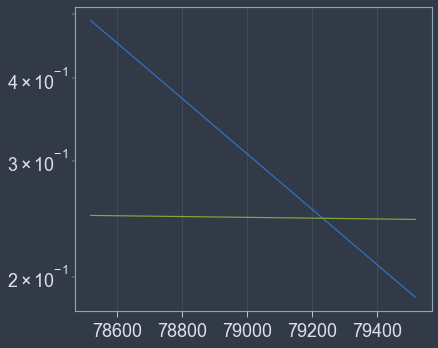

In [68]:
# Conditions
F= 2*10**15 # ord is the order factor on the flux 2*10^(ORD)
DefConst(F) # def constants for the given flux F

# find t_max
tmax= 24*60*60*7*10000
eps= 60*60
lamb= lambda x: N5(x,l1,l23,l24,l3,l4,l5)
t= GoldenSearch(lamb,1,tmax,eps,r=-1)

# conditions at t -> maximum activity
x0= np.zeros( 6 ) 
x0[0]= 0
x0[1]= N1(t, l1)
x0[2]= N2(t, l1, l2)
x0[3]= N4(t,l1,l23,l2,l3)
x0[4]= N4(t,l1,l24,l2,l4)
x0[5]= N5(t,l1,l23,l24,l3,l4,l5)


# Run Runge-Kuta (RK)
F= 0
DefConst(F)
N= 1000
h= 60*60/30 # time step
t0= 0
T= np.arange(0,N*h,h)

y= np.transpose( ODE_RK4(x0,f,N,h,t) )

# Activity plot
plt.figure( figsize=(19,10) )
plt.title("Activity")
# simulation
for i in range(len(x0)-1):
    plt.plot((T+t)/h, l_[i]*y[i], ms= 7, label="N"+str(i+1))

## Analytic
# LW=2
# Ta= np.linspace(0, t, 1000)
# plt.plot(Ta/h, N1(Ta, l1), "--k", lw=LW)
# plt.plot(Ta/h, N2(Ta, l1, l2),"--k", lw=LW)
# plt.plot(Ta/h, N4(Ta,l1,l23,l2,l3), "--k", lw=LW)
# plt.plot(Ta/h, N4(Ta,l1,l24,l2,l4),"--k", lw=LW)
# plt.plot(Ta/h, N5(Ta,l1,l23,l24,l3,l4,l5), "--k", lw=LW)
# plt.plot(0,0, "k--", label= "Analytic")
    
# plt.ylim((10**(-7),10**(-6)))
plt.yscale("log")
# plt.xscale("log")

plt.xlabel("$\\tau$="+str(h/(60*60*24))+" days")
plt.legend()
plt.show()

# # Activity plot
# plt.figure( figsize=(19,10) )
# plt.title("Activity")

# for i in (1,3,4):
#     plt.plot(T/h, l_[i]*y[i], "o", ms= 7, label= "N"+str(i+1))

# LW=2
# Ta= np.linspace(0, N*h, 1000)
# # plt.plot(Ta/h, l1*N1(Ta, l1), "--k", lw=LW)
# plt.plot(Ta/h, l2*N2(Ta, l1, l2),"--k", lw=LW)
# # plt.plot(Ta/h, l3*N4(Ta,l1,l23,l2,l3), "--k", lw=LW)
# plt.plot(Ta/h, l4*N4(Ta,l1,l24,l2,l4),"--k", lw=LW)
# plt.plot(Ta/h, l5*N5(Ta,l1,l23,l24,l3,l4,l5), "--k", lw=LW)
# plt.plot(0,0, "k--", label= "Analytic")
    
# plt.xlabel("$\\tau$="+str(h/(60*60*24))+" days")
# plt.legend()
# plt.yscale("log")
# plt.show()

plt.plot((T+t)/h, y[1], ms= 7, label="N"+str(1+1))
plt.plot((T+t)/h, y[3], ms= 7, label="N"+str(3+1))
plt.yscale("log")

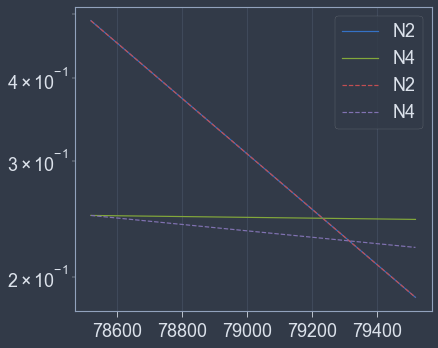

In [69]:
plt.plot((T+t)/h, y[1], ms= 7, label="N"+str(1+1))
plt.plot((T+t)/h, y[3], ms= 7, label="N"+str(3+1))

# l23= 8.056* 10**(-6)
# l4= 1.156*  10**(-7)

cons= 8.056* 10**(-6)
plt.plot((T+t)/h, x0[1]*np.exp(-cons*T), "--", label="N"+str(1+1) )

cons= 8.056* 1.156*  10**(-7)
plt.plot((T+t)/h, x0[3]*np.exp(-cons*T), "--", label="N"+str(3+1) )

plt.legend()
plt.yscale("log")

# Shifts simulation !(check axis scale)

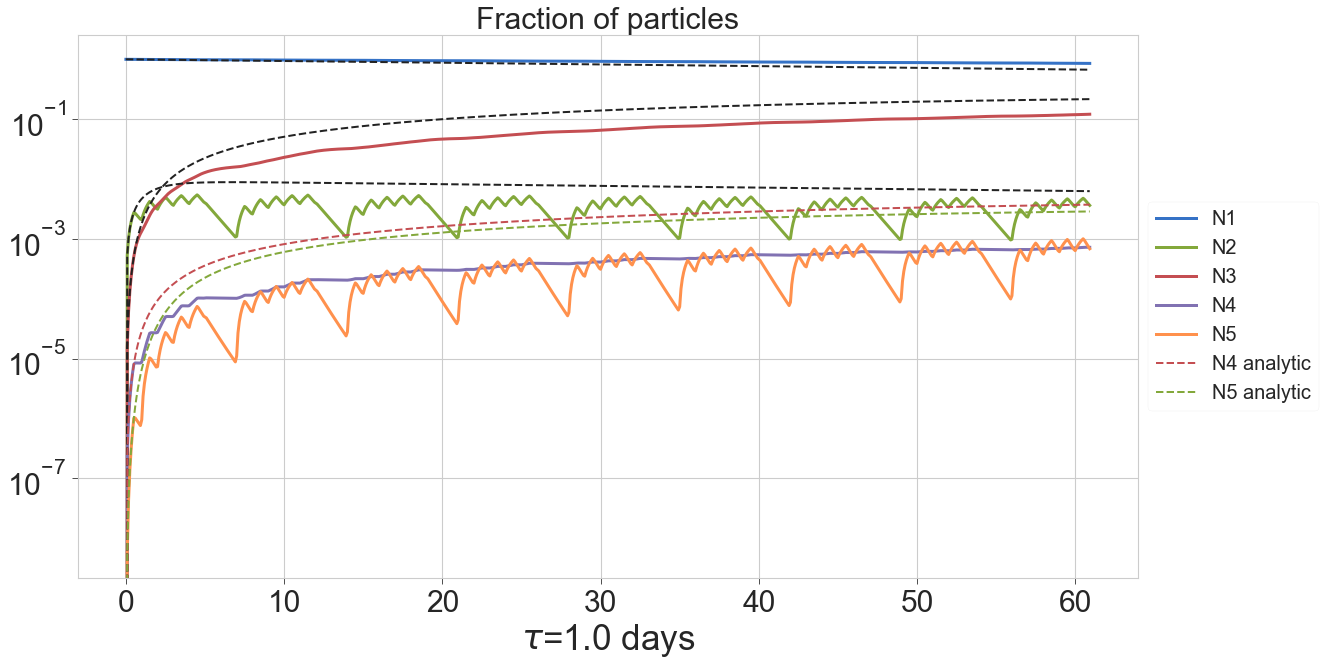

In [64]:
# Conditions
F= 2*10**15 # ord is the order factor on the flux 2*10^(ORD)

DefConst(F) # def constants for the given flux F
x0= np.array( (1,0,0,0,0,0) ) # initial conditions

# Run RK
Period= 12 #number or updates per day
N= (60+1)* Period

h= 24*60*60/Period # time step
t0= 0
T= np.arange(0,N*h,h)

y= np.transpose( ODE_RK4(x0,f_shift,N,h,t0) )

# Fraction of particles plot
plt.figure( figsize=(19,10) )
plt.title("Fraction of particles")
# simulation
for i in range(len(x0)-1):
    plt.plot(T/h/ Period, y[i], lw=3, label="N"+str(i+1))
    
LW=2 # analytic
plt.plot(T/h/ Period, N1(T, l1), "--k", lw=LW)
plt.plot(T/h/ Period, N2(T, l1, l2),"--k", lw=LW)
plt.plot(T/h/ Period, N4(T,l1,l23,l2,l3), "--k", lw=LW)
plt.plot(T/h/ Period, N4(T,l1,l24,l2,l4),"--r", lw=LW, label= "N4 analytic")
plt.plot(T/h/ Period, N5(T,l1,l23,l24,l3,l4,l5), "--g", lw=LW, label= "N5 analytic")

# plt.ylim((10**(-7),10**(-6)))
plt.yscale("log")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=20, markerscale=3)
plt.xlabel("$\\tau$="+str(h* Period/(60*60*24))+" days")
plt.show()

# Fraction of particles plot only for 4 and 5
# plt.figure( figsize=(19,10) )
# plt.title("Fraction of particles")
# # simulation

# for i in (3,4):
#     plt.plot(T/h/ Period, y[i], lw=3, label="N"+str(i+1))
    
# LW=2 # analytic
# plt.plot(T/h/ Period, N4(T,l1,l24,l2,l4),"--r", lw=LW, label= "N4 analytic")
# plt.plot(T/h/ Period, N5(T,l1,l23,l24,l3,l4,l5), "--g", lw=LW, label= "N5 analytic")

# # plt.ylim((10**(-7),10**(-6)))
# plt.yscale("log")
# plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=20, markerscale=3)
# plt.xlabel("$\\tau$="+str(h* Period/(60*60*24))+" days")
# # plt.ylim((10**-10,10**-6))
# # plt.xlim((24*60*60*7, 24*60*60*(7+1)))
# plt.show()

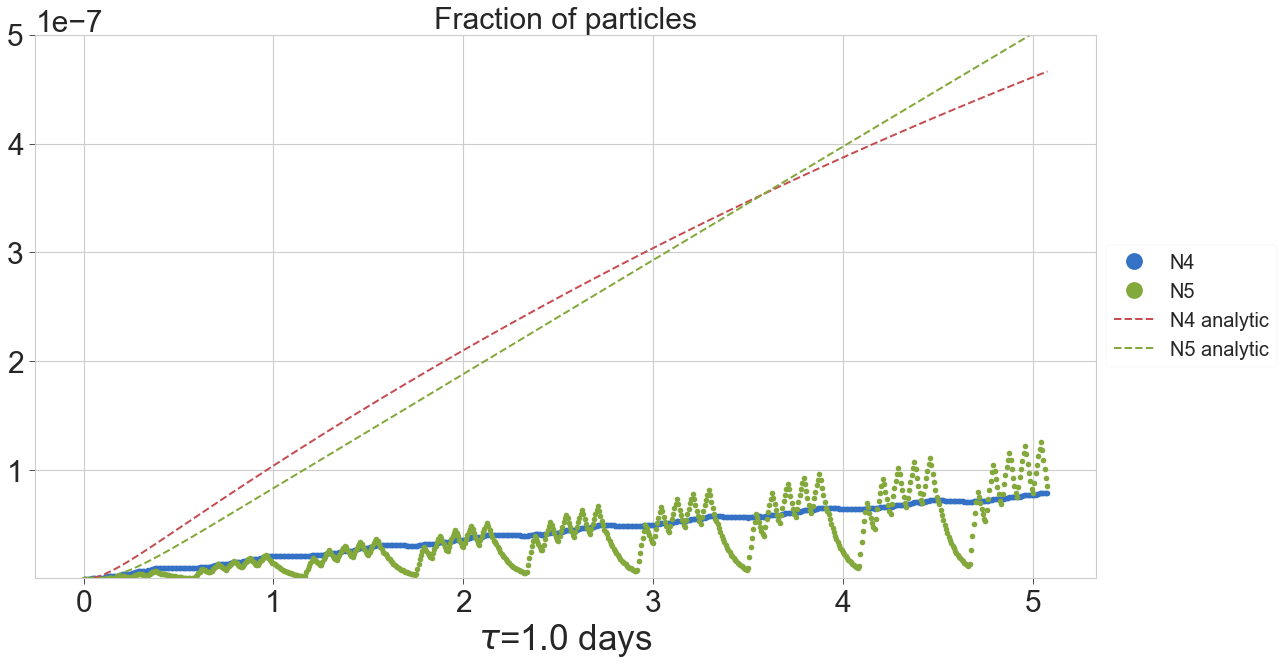

In [63]:
# Fraction of particles plot only for 4 and 5
plt.figure( figsize=(19,10) )
plt.title("Fraction of particles")
# simulation
n=5
for i in (3,4):
    plt.plot(T/(24*60*60)/Period, y[i],"o", lw=3, label="N"+str(i+1))
    
LW=2 # analytic
plt.plot(T/(24*60*60)/Period, N4(T,l1,l24,l2,l4),"--r", lw=LW, label= "N4 analytic")
plt.plot(T/(24*60*60)/Period, N5(T,l1,l23,l24,l3,l4,l5), "--g", lw=LW, label= "N5 analytic")


plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=20, markerscale=3)
plt.xlabel("$\\tau$="+str(h/(24*60*60)*Period)+" days")
plt.ylim((10**-9,0.5*10**-6))
# plt.yscale("log")
# N=3
# plt.xlim(  N, (N+1) )
plt.show()

# Accuracy test

In [53]:
def time(t):
    if t%604800>432000:  # if in the weekend, 
        shift= 0
    elif t%86400>43200: # if during the night
        shift= 0
    else:
        shift= 1
    return shift


0

# Testing the methods

[0.000e+00 8.056e-06 0.000e+00 1.156e-07 1.134e-05]


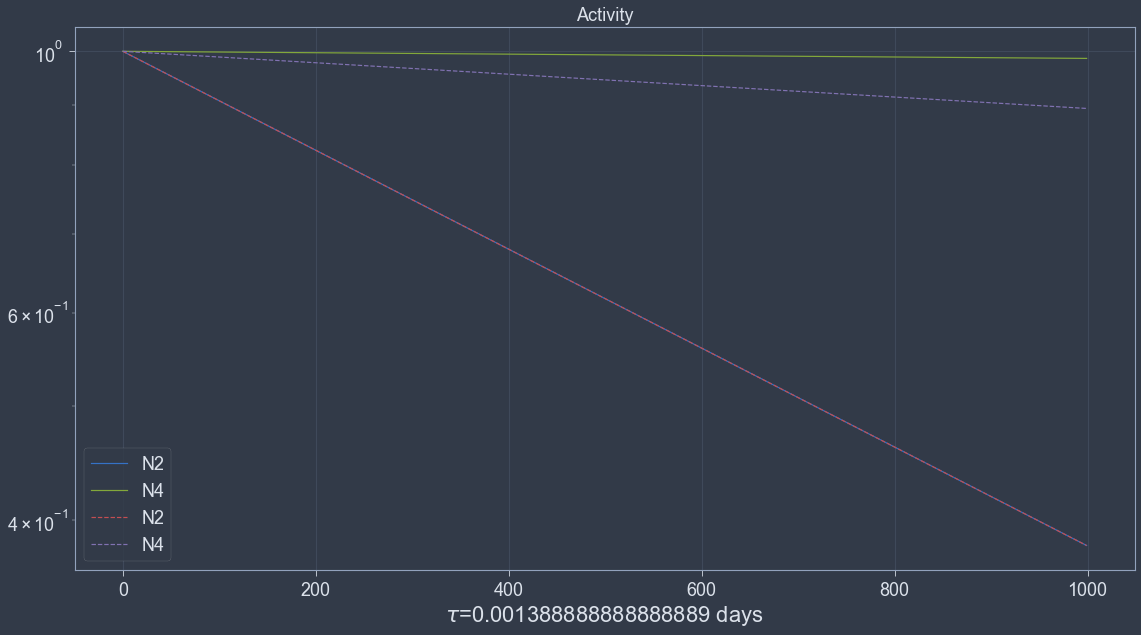

In [6]:
# conditions at t -> maximum activity
x0= np.zeros( 6 ) 
x0[0]= 0
x0[1]= 1
x0[2]= 0
x0[3]= 1
x0[4]= 0
x0[5]= 0

# Run Runge-Kuta (RK)
F= 0
DefConst(F)
N= 1000
h= 60*60/30 # time step
t0= 0
T= np.arange(0,N*h,h)
t=0
print(l_)

y= np.transpose( ODE_RK4(x0,f,N,h,0) )

# Activity plot
plt.figure( figsize=(19,10) )
plt.title("Activity")
# simulation
plt.plot((T+t)/h, y[1], ms= 7, label="N"+str(1+1))
plt.plot((T+t)/h, y[3], ms= 7, label="N"+str(3+1))

cons= 8.056* 10**(-6)
plt.plot((T+t)/h, np.exp(-cons*T), "--", label="N"+str(1+1) )

cons= 8.056* 1.156*  10**(-7)
plt.plot((T+t)/h, np.exp(-cons*T), "--", label="N"+str(3+1) )
    
# plt.ylim((10**(-7),10**(-6)))
plt.yscale("log")
# plt.xscale("log")

plt.xlabel("$\\tau$="+str(h/(60*60*24))+" days")
plt.legend()
plt.show()